In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
from scipy.optimize import least_squares

# V52 lidar study

In [2]:
tstart,tend = 40, 50
xstart,xend = 22.63, 23.98

In [3]:
vlos_data = '/Users/equon/WakeDynamics/V52_lidar_wake/vlos_digitized.csv'

## read digitized data 
- image from https://www.vindenergi.dtu.dk/english/news/2018/12/new-generation-of-wind-scanners-developed-by-dtu?id=21486c47-1a16-45da-b7f2-afad61e867e7
- digitized using https://apps.automeris.io/wpd/

In [4]:
df = pd.read_csv(vlos_data,header=None,names=['t','vlos'])

In [5]:
# distance from lidar [m]
df['x'] = (df['t']-tstart)/(tend-tstart) * (xend-xstart) + xstart

(-8, 8)

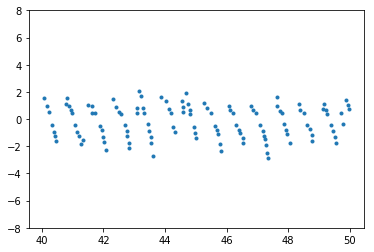

In [6]:
plt.plot(df['t'],df['vlos'],'.')
plt.ylim((-8,8))

## estimate passage frequency

In [7]:
dt = 0.1
t = np.arange(40+dt,50,dt)
Nt = len(t)

In [8]:
vlos = np.interp(t, df['t'], df['vlos'])

In [9]:
f = np.fft.fftfreq(Nt,d=dt)
S = np.fft.fft(vlos)

In [10]:
PSD = np.abs(S[:Nt//2])**2
imax = np.argmax(PSD)
fmax = f[imax]
print(fmax)

1.3131313131313131


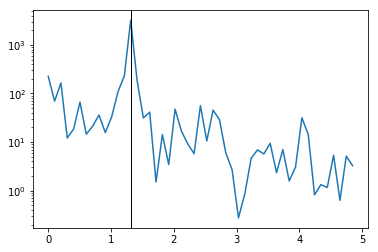

In [11]:
fig,ax = plt.subplots()
ax.semilogy(f[:Nt//2], PSD)
ax.axvline(fmax, color='k', lw=1)

In [12]:
T = 1/fmax
rotor_period = 3*T # 3 blades
rotor_rpm = 1/rotor_period * 60 # should be between 14 - 31.4 rpm
print('time between vortex passage:',T)
print(rotor_rpm,'rpm')

time between vortex passage: 0.7615384615384615
26.262626262626263 rpm


## split up periods

In [13]:
tlimits = np.arange(tstart,tend+T,T)

In [14]:
tlimits

array([40.        , 40.76153846, 41.52307692, 42.28461538, 43.04615385,
       43.80769231, 44.56923077, 45.33076923, 46.09230769, 46.85384615,
       47.61538462, 48.37692308, 49.13846154, 49.9       , 50.66153846])

In [15]:
df['period'] = pd.cut(df['t'], tlimits, labels=range(len(tlimits)-1))

(40, 50)

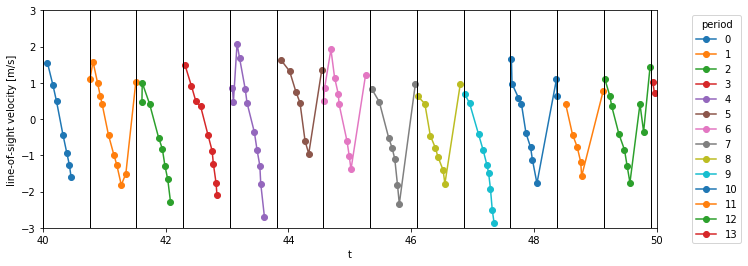

In [16]:
fig,ax = plt.subplots(figsize=(11,4))
df.set_index('t').pivot(columns='period')['vlos'].plot(ax=ax,marker='o')
for ti in tlimits:
    ax.axvline(ti,color='k',lw=1)
ax.legend(loc='upper left',bbox_to_anchor=(1.05,1),title='period')
ax.set_ylabel('line-of-sight velocity [m/s]')
ax.set_ylim((-3,3))
ax.set_xlim((tstart,tend))

## fit line of vortices to data

In [17]:
# guess = [1.0, T, 0, -0.5]
# bounds = (
#     [0.5, 0.5, -0.5, -1],
#     [2.0, 1.0, 0.5, 0],
# )
# def optfun(x):
#     strength, separation, toffset_frac, vbias = x
#     t0 = toffset_frac*separation + tstart
#     uthe = vort_soln(df['t'], separation=separation, strength=strength, tref=t0, vbias=vbias)
#     return uthe - df['vlos']

In [18]:
def rankine(r,**params):
    """Rankine vortex model
    
    For the core radius, there is an implicit conversion from time to length.
    """
    utheta = params['strength'] / (2*np.pi*r)
    in_core = np.where(np.abs(r) < params['rc'])
    utheta[in_core] = params['strength'] * r[in_core] / (2*np.pi*params['rc']**2)
    return utheta

In [19]:
def vort_line_soln(r,model=rankine,tol=0.1,**params):
    """Calculate solution for a line of vortices with the same orientation, neglecting
    mutual inductance. The tolerance determines the number of additional vortices to
    account for so that the induced velocity from the farthest vortex is `tol` m/s.
    
    Vortex model params:
    - separation: time between passage of subsequent vortices [s]
    - strength: vortex strength [m^2/s]
    - tref: time at which first vortex appears [s]
    - vbias: bias in vertical velocity, to account for wake expansion [m/s]
    - rcfrac: core radius, as a fraction of the separation distance [-]
    """
    sep = params['separation']
    if 'rcfrac' in params.keys():
        rcfrac = params.get('rcfrac')
        params['rc'] = rcfrac * sep
    r0 = np.mod(r-params['tref'], sep)
    r0[r0 > sep/2] -= sep
    Nvort = params['strength'] / (2*np.pi*sep) / tol
    Nvort = int(np.ceil(Nvort))
    u = model(r0, **params)
    for i in range(1,Nvort+1):
        u += model(r0-i*sep, **params)
        u += model(r0-i*sep, **params)
    return u + params['vbias']

In [20]:
def optimize_vort_soln(model,params_guess_bounds):
    """Perform least-squares optimization for the solution from a line of vortices,
    given a vortex model and a set of parameters to be optimized.
    """
    guess = []
    bounds = [[],[]]
    for param, guess_bounds in params_guess_bounds.items():
        guess.append(guess_bounds[0])
        bnds = guess_bounds[1]
        bounds[0].append(bnds[0])
        bounds[1].append(bnds[1])
        print(param,'guess/bounds:',guess[-1],(bounds[0][-1],bounds[1][-1]))
    def optfun(x):
        vortparams = {key: val for key,val in zip(params_guess_bounds.keys(), x)}
        uthe = vort_line_soln(df['t'].values, model=model, **vortparams)
        return uthe - df['vlos']
    return least_squares(optfun, guess, bounds=bounds, verbose=2)

In [27]:
soln = optimize_vort_soln(rankine, OrderedDict(
    strength=[1.0, (0.5, 2.0)],
    separation=[T, (0.5, 1.0)],
    tref=[tstart, (tstart-1.0, tstart+1.0)],
    vbias=[-0.5, (-1, 0)],
    rcfrac=[0.2, (0.01, 0.5)],
))

strength guess/bounds: 1.0 (0.5, 2.0)
separation guess/bounds: 0.7615384615384615 (0.5, 1.0)
tref guess/bounds: 40 (39.0, 41.0)
vbias guess/bounds: -0.5 (-1, 0)
rcfrac guess/bounds: 0.2 (0.01, 0.5)
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1313e+02                                    6.15e+02    
       1              2         5.0763e+01      6.24e+01       3.62e-01       2.27e+02    
       2              3         3.6214e+01      1.45e+01       2.09e-01       8.84e+01    
       3              5         3.5480e+01      7.35e-01       2.82e-02       9.11e+01    
       4              6         3.4934e+01      5.46e-01       2.63e-02       3.40e+01    
       5              8         3.4693e+01      2.41e-01       9.97e-03       2.19e+01    
       6             10         3.4590e+01      1.03e-01       4.83e-03       8.86e+00    
       7             12         3.4540e+01      4.95e-02       2.23e-03   

In [ ]:
errors = soln['fun']
print(soln['x'],np.sqrt(errors.dot(errors)))

separation 0.9523774817441062
strength 0.7578779239367963
delta_t0/separation 39.96589840082783
vbias -0.038864129914344236
r_c/separation 0.10272353968925134


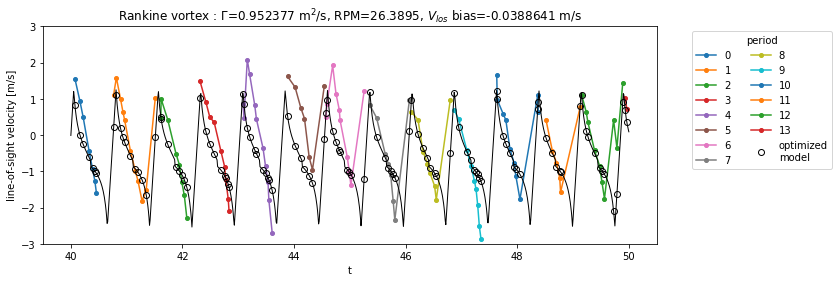

In [25]:
fig,ax = plt.subplots(figsize=(11,4))

# lidar data
df.set_index('t').pivot(columns='period')['vlos'].plot(ax=ax,marker='o',markersize=4)

# optimized vortex solution, at same times as lidar data
strength, separation, tfrac, vbias, rcfrac = soln['x']
t0 = tfrac*separation + tstart
ax.plot(df['t'], vort_line_soln(df['t'].values,
                                separation=separation, strength=strength, tref=t0, vbias=vbias, rcfrac=rcfrac),
                                'ko', markerfacecolor='none', label='optimized\nmodel')

# show vortex solution at higher resolution
tt = np.linspace(40,50,1001)
ax.plot(tt, vort_line_soln(tt, separation=separation, strength=strength, tref=t0, vbias=vbias, rcfrac=rcfrac),
        'k-', lw=1)

ax.legend(loc='upper left',bbox_to_anchor=(1.05,1),
          title='period',ncol=2)
ax.set_ylabel('line-of-sight velocity [m/s]')
ax.set_ylim((-3,3))
ax.set_title(r'Rankine vortex : $\Gamma$={:g} m$^2$/s, RPM={:g}, $V_{{los}}$ bias={:g} m/s'.format(
    strength, 60/(3*separation), vbias
))

fig.savefig('figures/rankine_soln.png',bbox_inches='tight')

for name,val in zip(['separation', 'strength', 'delta_t0/separation', 'vbias', 'r_c/separation'], soln['x']):
    print(name,val)